# Demonstration of anomaly detection with CVAE using DASHlink data

**Author: Milad Memarzadeh (milad.memarzadeh@nasa.gov)**

In this notebook, we first learn about CVAE (Convolutional Variational Auto-Encoder) and its different components. Then, we will apply CVAE to a dataset from DASHlink project (https://c3.ndc.nasa.gov/dashlink/projects/85/) for anomaly detection.

### Part 1. What is a Variational Auto-Encoder?

In this part, we first learn about the Variational Auto-Encoders (VAEs) and their use cases. VAEs are the generalization of Auto-Encoders that learn a lower-dimensional representation of the data using nonlinear transformations through neural networks in an unsupervised fashion. They are sometimes referred to as nonlinear Principal Component Analysis (PCA). The consists of two main components: (1) an encoder, $q_{\phi}(z \mid x)$, that maps the input data $𝑋$ to a lower-dimensional space, $𝑍$ (which is also called latent space), and (2) a decoder, $p_{\theta}(x \mid z)$ that reconstructs the original data $\hat{X}$ by sampling from the low-dimensional latent space. Both encoder and decoder are parameterized by neural networks. 

VAEs use a regularizer to control the complexity of the distribution of the learned representations in the latent space. the main goal is that with proper regularization of the posterior distribution of the data in the latent space, i.e., $q_{\phi}(z \mid x)$, the model will be able to generalize better to an unseen data. They are trained based on two optimization objectives: (1) to optimize the quality/fidelity of the reconstructed data compared to the original ones, and (2) to regularize the posterior distribution of the latent space to not form a very complex distribution. This objective does not allow the model to overfit to the training data and be able to generalize to an unseen data with higher accuracy. The first objective is imposed by minimizing the reconstruction error, which can be calculated as a mean squared error between the input and the output, i.e., $\lVert X - \hat{X} \rVert_{2}^{2}$ or maximizing the log-likelihood of the generated data. The second objective is imposed by minimizing the KL-divergence between the posterior distribution of the latent feature space and its prior distribution. In most cases, the prior/posteriors are assumed to form a multivariate Gaussian distribution. Given this, the overal objective function is defined as follows,

$$\mathcal{L}( \theta, \phi ; \beta, x, z) = \mathbb{E}_{q_{\phi}(z \mid x)}[\log p_{\theta}(x \mid z) - \beta \text{KL}(q_{\phi}(z \mid x) \Vert p(z))]$$

where $\beta$ controls the effect of regularization term on the overal training.

### Part 2. Convolutional VAE (CVAE)

CVAE takes advantage of the convolutional neural networks to learn about the short-term as well as long-term temporal dependence in the input data. This is in comparison to fully connected neural networks that won't incorporate such temporal dependece. As a result, it is well-suited to work with multivariate time-series data. Figure below shows the illustration of the CVAE's architecture:


<img src="cvae_arch.png" alt="Drawing" style="width: 400px;"/>


CVAE uses windowed time-series data as an input and applies series of convolutional operations with different filter sizes to take multiple local temporal dependencies into account. Then, the results of each series of convolutions are concatenated and mapped to the latent space. We use a similar architecture for both the encoder and the decoder. As a result, the decoder consists of a series of deconvolution and up-sampling with different filter sizes. Each branch of the encoder has four convolutional layers followed by a pooling layer, of which the number of input channels increases as the window size shrinks. Similarly, the decoder consists of four layers of de-convolution followed by an up-sampling layer, the number of input channels of which decreases as the window size expands.

CVAE can be used for multiple purposes. It is an unsupervised reasoning model and does not require availability of labeled data for training. It is often used for:

1. **Non-linear dimensionality reduction**: in this setting, it can be understood as a nonlinear Principal Component Analysis (PCA), where it uses series of nonlinear transformations to learn a lower-dimensional representation of the input data.

2. **Anomaly detection**: if the training data consists mostly of nominal cases and few anomalies, one can imagine that training the model to reconstruct such data would only optimize this for the majority nominal data present in the training. Then, the reconstruction error can be used to detect those anomalous out-of-distribution data instances.


3. **Data generation and augmentation**: once trained, CVAE can be used to generate and augment databases. One can perform random walks in the latent feature space and synthesize new data instances that are from the same distribution as the original input data.

In this notebook, we will explore application of CVAE in finding anomalies in the final approach to landing of the commercial aircraft. We specifically focus on finding anomalies that are related to late deployment of the flaps, which results in a high speed and unstable approach to landing.

### Part 3. Final approach to landing data from DASHlink project

The is a Flight Operational Quality Assurance (FOQA) data of a commerical airline from DASHlink project (link at the top of the notebook). It comprises primarily 1-Hz recordings for each flight and covers a variety of systems. These include: the state and orientation of the aircraft, positions and inputs of the control surfaces, engine parameters, and auto pilot modes and corresponding states. The data is acquired in real time on-board the aircraft and downloaded by the airline once the aircraft has reached the destination gate. These time series are analyzed by domain experts, which derive threshold-based rules post-flight to flag known events and create labels. Each data instance is a 160 s long recording of 10 variables during the approach of the aircraft to landing (from a few seconds before an altitude of 1000 ft to a few seconds after an altitude of 500 ft). 

As mentioned before, we will focus on finding anomalies that are related to late deployment of the flaps, which results in a high speed and unstable approach to landing. Let us take a look at a sample of nominal and anomalous data instances. 

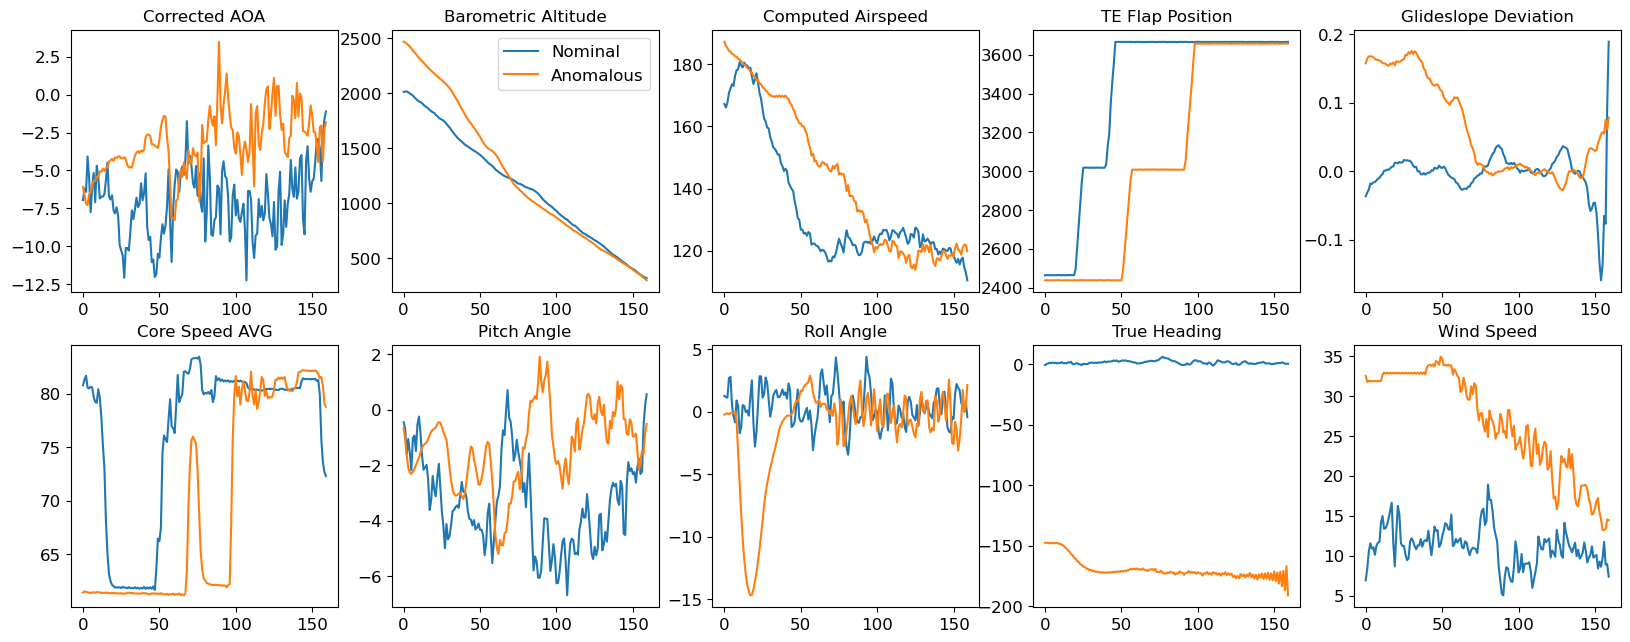

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

main_dir = os.path.dirname(os.getcwd())
os.chdir(main_dir)
dir_2_data = "./data/"
loading_dir = "./output/"

sample_data = np.load(dir_2_data+"Sample_raw_data.npz")

plt.figure(figsize=(20, 7.5))

for i in range(len(sample_data['param_names'])):
    plt.subplot(2, 5, i+1)
    plt.plot(sample_data['nominal'][:, i], label='Nominal', c='C0')
    plt.plot(sample_data['anomaly'][:, i], label='Anomalous', c='C1')
    plt.title(sample_data['param_names'][i])
    if i == 1:
        plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)

Now, let us load the entirety of the training and testing data and take a closer look:

In [2]:
train_data = np.load(dir_2_data+"DASHlink_binary_Flaps_noAnomaly_train.npz")
test_data = np.load(dir_2_data+"DASHlink_binary_Flaps_noAnomaly_test.npz")
x_train = train_data['data']
x_test = test_data['data']
y_test = test_data['label']


window_size = np.shape(x_train)[1]
num_param = np.shape(x_train)[2]


print("We have {} training data and {} testing data".format(np.shape(x_train)[0], np.shape(x_test)[0]))
print("Distribution of the data in the testing set (0: Nominal, 1: Anomaly):")
print(np.unique(y_test, return_counts=True))

We have 12219 training data and 4215 testing data
Distribution of the data in the testing set (0: Nominal, 1: Anomaly):
(array([0., 1.], dtype=float32), array([4030,  185]))


### Part 4. Training CVAE

In this section, we show you steps that needs to be take to train the CVAE. Although, we will only load up a trained model later on, we will show you details of the steps here:


Let us first start with preparing the data loaders for the model training

In [ ]:
import torch
from source.models import *
from source.utils import *
#cuda = torch.cuda.is_available()
# PyTorch wants the number of params to be the first dimension and the window size to be the second dimension
x_train = np.transpose(x_train, axes=(0, 2, 1))
x_test = np.transpose(x_test, axes=(0, 2, 1))
print("Shape of the training data: {}".format(x_train.shape))
print("Shape of the testing data: {}".format(x_test.shape))
# Preparing training and testing datasets
train = Dataset(x_train)
test = Dataset(x_test)

# Preparing the data loader
batch_size = 128
train_data, test_data = get_dataset(train, test, batch_size)

Now let us configure a model and train it:

In [4]:
num_epochs = 100 # Number of epochs for training
latent_dim = 32 # dimension of the latent space
beta = 0.001 # value of beta that controls the regularization
metric = 'BCE' # choice of metric for calculating reconstruction error
training = 1 # whether to train the model or load a trained one


# Naming the model for saving
model_name = ("Demo_CVAE_l_"+(str(latent_dim))+"_beta_"+(str(beta))+
              "_batch_"+str(batch_size)+"_metric_"+metric)

# initiating the model
model = VAE(latent_dim=latent_dim, num_param=num_param, window_size=window_size, scale_flag=0)

# setting up the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

# training or loading the trained model:
if training:
    model = train_model(model, optimizer, model_name, train_data, test_data,loading_dir,
                   metric, beta, num_epochs, save=True, verbose=1)
    #model = model.to("cuda")
else:
    model.load_state_dict(torch.load((loading_dir+model_name+".pth"),
                          map_location=torch.device('cpu')))
    print("Model loaded!")

using:  cuda
Number of Epochs:  100
Epoch: 0,  Duration: 2.14
[Loss Train]		 L: 975.1225, Rec: 975.0837, , KL: 38.7647
[Loss Validation]		 L: 953.8530
Epoch: 1,  Duration: 1.77
[Loss Train]		 L: 945.9776, Rec: 945.9211, , KL: 56.5420
[Loss Validation]		 L: 941.7778
Epoch: 2,  Duration: 1.80
[Loss Train]		 L: 934.8238, Rec: 934.7539, , KL: 69.9035
[Loss Validation]		 L: 933.8678
Epoch: 3,  Duration: 1.75
[Loss Train]		 L: 925.9588, Rec: 925.8778, , KL: 81.0536
[Loss Validation]		 L: 922.1937
Epoch: 4,  Duration: 1.74
[Loss Train]		 L: 918.6260, Rec: 918.5358, , KL: 90.1940
[Loss Validation]		 L: 919.4400
Epoch: 5,  Duration: 1.72
[Loss Train]		 L: 912.3549, Rec: 912.2564, , KL: 98.5340
[Loss Validation]		 L: 911.4338
Epoch: 6,  Duration: 1.73
[Loss Train]		 L: 906.6362, Rec: 906.5287, , KL: 107.4842
[Loss Validation]		 L: 908.1197
Epoch: 7,  Duration: 1.73
[Loss Train]		 L: 901.9959, Rec: 901.8774, , KL: 118.5564
[Loss Validation]		 L: 897.0873
Epoch: 8,  Duration: 1.72
[Loss Train]		 L

### Part 5. Training statistics

We have also saved the trajectory of training losses that we can visualize to make sure that the model has trained properly:

**Note:** if you train a new model, this should be saved in your directory.

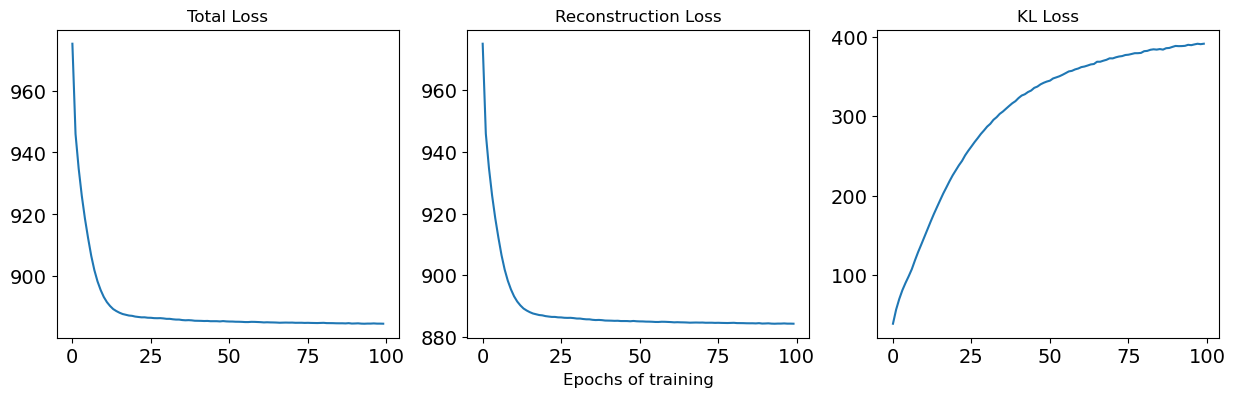

In [5]:

training_traj = np.load(loading_dir+model_name+"_training_loss.npz")

total_loss = training_traj['training_total_loss']
rec_loss = training_traj['training_rec_loss']
kl_loss = training_traj['training_kl_loss']


plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Total Loss", fontsize=12)
plt.plot(range(num_epochs), total_loss)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.subplot(1, 3, 2)
plt.title("Reconstruction Loss", fontsize=12)
plt.plot(range(num_epochs), rec_loss)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Epochs of training", fontsize=12)
plt.subplot(1, 3, 3)
plt.title("KL Loss", fontsize=12)
plt.plot(range(num_epochs), kl_loss)
plt.tick_params(axis='both', which='major', labelsize=14)

### Part 6. Performance evaluation on the testing set

Now that we have trained a model, we will use it to identify anomalies in the testing set and evaluate how accurate we are. First, we need to calculate the threshold for anomaly detection based on reconstruction error of the training set:

In [6]:
# finding a threshold for anomaly detection 

## Please note that this step might take a while. A smaller num_sample will
### speed up this step with a trade-off of a less accurate estimate of the threshold.
#### for the sake of time, we have saved the results of this step and will load it here:

scale = 2 # how many std from mean should we use to set up the threshold
#model = model.to("cuda")
train_anomaly_score = find_score(model, x_train, metric, num_sample=50)
np.savez_compressed(loading_dir+model_name+"_train_scores", scores=train_anomaly_score)

train_anomaly_score = np.load(loading_dir+model_name+"_train_scores.npz")['scores']
threshold = np.mean(train_anomaly_score) + scale * np.std(train_anomaly_score)

using: cpu


In [7]:
# Once we find the threshold, we can use it to identify anomalies in the test set

model_preds = np.zeros(np.shape(x_test)[0])

# calculating the anomaly scores on the test set (again, for the sake of time, we will load this)
test_anomaly_score = find_score(model, x_test, metric, num_sample=50)
np.savez_compressed(loading_dir+model_name+"_test_scores.npz", scores=test_anomaly_score)

test_anomaly_score = np.load(loading_dir+model_name+"_test_scores.npz")['scores']
model_preds[test_anomaly_score > threshold] = 1

using: cpu


Graph below, shows the histogram of the anomaly scores for the nominal and anomalous data samples in the testing set. We can see that for the nominal data, the score is generally lower and less variant, while it is much more variant and generally higher for the anomalous data samples. 

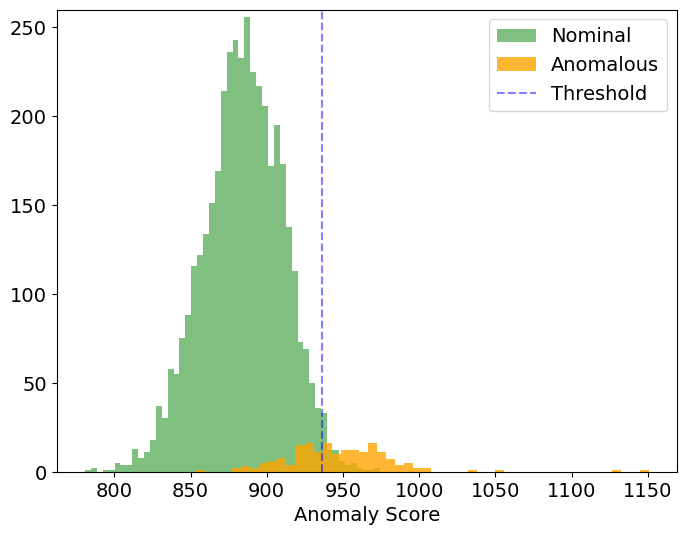

In [8]:
ind_nominal = np.where(y_test==0)[0]
ind_anomaly = np.where(y_test==1)[0]

plt.figure(figsize=(8, 6))
plt.hist(test_anomaly_score[ind_nominal], bins=50, alpha=0.5, color='Green', label='Nominal')
plt.hist(test_anomaly_score[ind_anomaly], bins=50, alpha=0.8, color='Orange', label='Anomalous')
plt.vlines(threshold, 0, 300, color='blue', linestyle='dashed', alpha=0.5, label='Threshold')
plt.ylim(0, 260)
plt.xlabel("Anomaly Score", fontsize=14)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

Below numbers are the precision, recall and F1-score of the performance on the testing set. They are defined as follow,


$$ \text{precision} = \frac{TP}{TP + FP}$$

$$ \text{recall} = \frac{TP}{TP + FN}$$

where $TP$ is true positive: anomalies that are correctly identified, $FP$ is false positive (or false alarms):
anomalies that are incorrectly identified, and $FN$ is false negative, or anomalies that are missed and classified as nominal by mistake.

F1-score is the harmonic mean of the two above metrics and it is easier to choose, because one can makes the decision based on only one metric:

$$ \text{F1-score} = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$


In [9]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
info = precision_recall_fscore_support(y_test, model_preds, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

Precision = 61.75%, recall = 61.08% and F1-score = 61.41%


Below, we also visualize the confusion matrix that shows the correct and wrong classifications for each class:

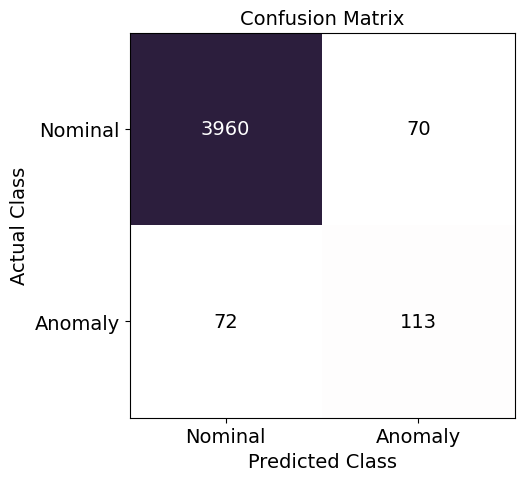

In [10]:
import seaborn as sns

cm = confusion_matrix(y_test, model_preds)


FONT = 14
classes = ['Nominal', 'Anomaly']
#plt.figure(figsize=(8, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax1 = plt.subplots(1, figsize=(5, 5))

im = ax1.imshow(cm, cmap=cmap)
ax1.set_title("Confusion Matrix", fontsize=FONT)
ax1.set_xticks(np.arange(len(classes)))
ax1.set_xticklabels("")
ax1.set_yticks(np.arange(len(classes)))
ax1.set_xticklabels(classes, rotation=0)
ax1.set_ylim(len(classes)-0.5, -0.5)
ax1.set_yticklabels(classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        if cm[j, i] > 1000:
            cc = 'white'
        else:
            cc = 'black'
        text = ax1.text(i, j, cm[j, i],
                       ha="center", va="center", color=cc, fontsize=FONT)
ax1.set_ylabel("Actual Class", fontsize=FONT)
ax1.set_xlabel("Predicted Class", fontsize=FONT)
ax1.tick_params(axis='both', which='major', labelsize=FONT)

### Part 7. Structure of the data in the latent feature space

In this part, we use t-Stochastic Neighbour Embedding (t-SNE) to visualize the 32-dimensional latent feature space in 2D and color code each data sample by the class it belongs to in order to better understand the structure of the learned feature space. 

In [11]:
from sklearn.manifold import TSNE
model.eval()

# obtaining latent variables
z_test = model.encoder(torch.from_numpy(x_test))[0].detach().numpy()

# using t-SNE to map latnet variables to 2D
tsne_test = TSNE(n_components=2, perplexity=50, init='pca', random_state=33).fit_transform(z_test)

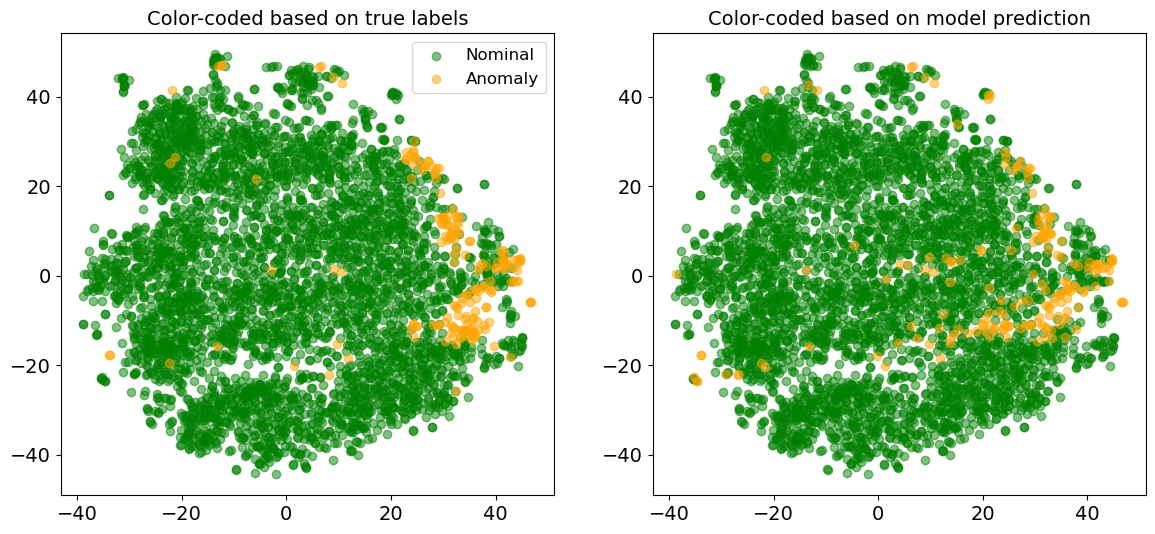

In [12]:
colors = ['Green', 'Orange']
labels = ['Nominal', 'Anomaly']
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("Color-coded based on true labels", fontsize=14)
for i in range(2):
    indices = np.where(y_test==i)[0]
    plt.scatter(tsne_test[indices, 0], tsne_test[indices, 1], label=labels[i], c=colors[i], alpha=0.5)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.subplot(1, 2, 2)
plt.title("Color-coded based on model prediction", fontsize=14)
for i in range(2):
    indices = np.where(model_preds==i)[0]
    plt.scatter(tsne_test[indices, 0], tsne_test[indices, 1], label=labels[i], c=colors[i], alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=14)
